# PR0505. Análisis de estadísticas en dataset

In [4]:
from pyspark.sql.types import StringType, IntegerType, DoubleType, StructType, StructField 
schema = StructType([
    StructField("Index", IntegerType(), False),
    StructField("Title", StringType(), False),
    StructField("Description", StringType(), False),
    StructField("Amount(in rupees)", StringType(), False),
    StructField("Price (in rupees)", IntegerType(), True),
    StructField("location", StringType(), False), 
    StructField("Carpet Area", StringType(), False),
    StructField("Status", StringType(), False),
    StructField("Floor", StringType(), False),
    StructField("Transaction", StringType(), False),
    StructField("Furnishing", StringType(), False),
    StructField("facing", StringType(), True),
    StructField("overlooking", StringType(), True),
    StructField("Society", StringType(), True),
    StructField("Bathroom", IntegerType(), False),
    StructField("Balcony", IntegerType(), True),
    StructField("Car Parking", StringType(), True),
    StructField("Ownership", StringType(), True),
    StructField("Super Area", StringType(), True),
    StructField("Dimensions", StringType(), True),
    StructField("Plot Area", StringType(), True),
])

In [5]:
from pyspark.sql import SparkSession

spark = (
    SparkSession
        .builder
        .appName("Estadisticas")
        .master("spark://spark-master:7077")
        .getOrCreate()
)

df = (
    spark
        .read
        .format("csv")
        .schema(schema)
        .option("header", "true")
        .load("/workspace/pr0505/house_prices.csv")
)

df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/18 11:06:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-----+--------------------+--------------------+-----------------+-----------------+--------+-----------+-------------+------------+-----------+--------------+------+--------------------+--------------------+--------+-------+-----------+--------------------+----------+----------+---------+
|Index|               Title|         Description|Amount(in rupees)|Price (in rupees)|location|Carpet Area|       Status|       Floor|Transaction|    Furnishing|facing|         overlooking|             Society|Bathroom|Balcony|Car Parking|           Ownership|Super Area|Dimensions|Plot Area|
+-----+--------------------+--------------------+-----------------+-----------------+--------+-----------+-------------+------------+-----------+--------------+------+--------------------+--------------------+--------+-------+-----------+--------------------+----------+----------+---------+
|    0|1 BHK Ready to Oc...|Bhiwandi, Thane h...|          42 Lac |             6000|   thane|   500 sqft|Ready to Move|10 o

## 1. Objetivos de ingeniería de datos (ETL)
### 1.1. Estandarización monetaria (de INR a USD)

In [6]:
from pyspark.sql.functions import col, when, split
df = (
    df.withColumn("Amount_USD",
        when(split(col("Amount(in rupees)"), " ").getItem(1) == "Lac", split(col("Amount(in rupees)"), " ").getItem(0).cast("int") * 100_000 * 0.012)
        .otherwise(split(col("Amount(in rupees)"), " ").getItem(0).cast("float") * 10_000_000 * 0.012)
     )
)
df.show(5)

+-----+--------------------+--------------------+-----------------+-----------------+--------+-----------+-------------+------------+-----------+--------------+------+--------------------+--------------------+--------+-------+-----------+--------------------+----------+----------+---------+----------+
|Index|               Title|         Description|Amount(in rupees)|Price (in rupees)|location|Carpet Area|       Status|       Floor|Transaction|    Furnishing|facing|         overlooking|             Society|Bathroom|Balcony|Car Parking|           Ownership|Super Area|Dimensions|Plot Area|Amount_USD|
+-----+--------------------+--------------------+-----------------+-----------------+--------+-----------+-------------+------------+-----------+--------------+------+--------------------+--------------------+--------+-------+-----------+--------------------+----------+----------+---------+----------+
|    0|1 BHK Ready to Oc...|Bhiwandi, Thane h...|          42 Lac |             6000|   tha

### 1.2. Estandarización de superficie

In [7]:
df = (
    df
        .withColumn("Carpet Area", split(col("Carpet Area"), " ").getField(0).cast("float") * 0.0929)
)
df.show(5)

+-----+--------------------+--------------------+-----------------+-----------------+--------+------------------+-------------+------------+-----------+--------------+------+--------------------+--------------------+--------+-------+-----------+--------------------+----------+----------+---------+----------+
|Index|               Title|         Description|Amount(in rupees)|Price (in rupees)|location|       Carpet Area|       Status|       Floor|Transaction|    Furnishing|facing|         overlooking|             Society|Bathroom|Balcony|Car Parking|           Ownership|Super Area|Dimensions|Plot Area|Amount_USD|
+-----+--------------------+--------------------+-----------------+-----------------+--------+------------------+-------------+------------+-----------+--------------+------+--------------------+--------------------+--------+-------+-----------+--------------------+----------+----------+---------+----------+
|    0|1 BHK Ready to Oc...|Bhiwandi, Thane h...|          42 Lac |   

## 2. Objetivos de análisis estadístico
### 2.1. Medidas de dispersión (varianza y desviación estándar)

In [8]:
from pyspark.sql.functions import std, variance, avg, max, median


print("Máximo: ")
df.select(max(col("Amount_USD"))).show(truncate=False)
print("Media: ")
df.select(avg(col("Amount_USD"))).show(truncate=False)
print("Mediana: ")
df.select(median(col("Amount_USD"))).show(truncate=False)
print("Varianza: ")
df.select(variance(col("Amount_USD"))).show(truncate=False)
print("Desviación estándar: ")
df.select(std(col("Amount_USD"))).show()

Máximo: 
+---------------+
|max(Amount_USD)|
+---------------+
|1.6803600384E8 |
+---------------+

Media: 
+-----------------+
|avg(Amount_USD)  |
+-----------------+
|143673.9094809754|
+-----------------+

Mediana: 
+------------------+
|median(Amount_USD)|
+------------------+
|93600.0           |
+------------------+

Varianza: 
+---------------------+
|var_samp(Amount_USD) |
+---------------------+
|2.2369053492349777E11|
+---------------------+

Desviación estándar: 
+------------------+
|   std(Amount_USD)|
+------------------+
|472959.33749477635|
+------------------+



La desviación estándar es más o menos tres veces la media. No es una locura, pero sí que es cierto que puede parecer bastante, sobre todo a la escala a la que están los datos. Confiar en el promedio en este caso no sería lo adecuado.

### 2.2. Medidas de Forma (Skewness y Kurtosis)

In [9]:
from pyspark.sql.functions import skewness, kurtosis

print("Asimetría: ")
df.select(skewness(col("Amount_USD"))).show()
print("Coeficiente de curtosis: ")
df.select(kurtosis(col("Amount_USD"))).show()

Asimetría: 
+--------------------+
|skewness(Amount_USD)|
+--------------------+
|   270.7528623538977|
+--------------------+

Coeficiente de curtosis: 
+--------------------+
|kurtosis(Amount_USD)|
+--------------------+
|   91483.85780267783|
+--------------------+



- La curva tiene un valor positivo (de 270, una barbaridad, es probable que haya algún dato mal tomado) por tanto la mayoría de las casas se concentran en los precios bajos y hay pocas casas caras, pero las que hay son muy caras, puede que en el ámbito de millones o puede que cientos de millones (la casa con mayor valor llega casi a los 200 millones de dólares).
- El valor de Curtosis es muy alto, por tanto, hay muchos valores muy concentrados, pero es extremadamente sensible a los valores extremos. Es poco probable que los datos de precio sean erróneos (ciertamente hay casas muy caros), pero sí que es cierto que estos pocos valores están distorsionando los datos. En este caso, sería una buena idea pasar los datos a escala logarítmica.

## 3. Interpretación para IA
### 3.1.- Pre-procesamiento para redes neuronales:

In [ ]:
stats = df.select(
    avg("Amount_USD").alias("avg_usd"),
    std("Amount_USD").alias("std_usd")
).collect()[0]

avg_usd = stats["avg_usd"]
std_usd = stats["std_usd"]

stats = df.select(
    avg("Carpet Area").alias("avg_area"),
    std("Carpet Area").alias("std_area")
).collect()[0]

avg_area = stats["avg_area"]
std_area = stats["std_area"]

df_normalized = (
    df
        .withColumn("Amount_USD_Z_Score", (col("Amount_USD") - avg_usd) / std_usd)
        .withColumn("Carpet_Area_Z_Score", (col("Carpet Area") - avg_area) / std_area)
)
df_normalized.select("Amount_USD_Z_Score").show(5)
df_normalized.select("Carpet_Area_Z_Score").show(5)
df_normalized.select(max("Amount_USD_Z_Score")).show()

+--------------------+
|  Amount_USD_Z_Score|
+--------------------+
| -0.1972133798542577|
|-0.05512928366968411|
| 0.05143378846874608|
|-0.24034605191028896|
| 0.10217810853466522|
+--------------------+
only showing top 5 rows

+--------------------+
| Carpet_Area_Z_Score|
+--------------------+
|-0.22972093599364965|
|-0.23858078173842762|
|-0.13816919663094365|
| -0.2198766629438963|
|-0.18542170726975965|
+--------------------+
only showing top 5 rows

+-----------------------+
|max(Amount_USD_Z_Score)|
+-----------------------+
|      354.9825886086313|
+-----------------------+



In [15]:
!pip install pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 9.5 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 23.0.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


    Comprobación de valores extremos

143673.90948097498 93600.0
        Amount_USD
0        50400.000
1       117600.000
2       168000.000
3        30000.000
4       192000.000
...            ...
187526   75600.000
187527   66000.000
187528   91200.000
187529   36000.000
187530  141599.988

[187531 rows x 1 columns]


/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


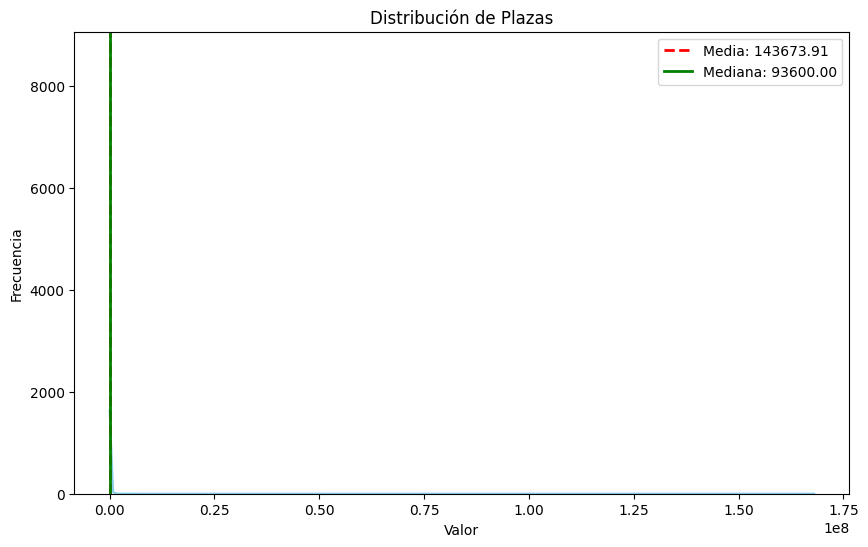

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
df_pandas = df.select("Amount_USD").toPandas()
media = df_pandas["Amount_USD"].mean()
mediana = df_pandas["Amount_USD"].median()
print(media, mediana)
print(df_pandas)
plt.figure(figsize=(10, 6))
sns.histplot(df_pandas["Amount_USD"], kde=True, color="skyblue")

# plt.xlim(0, 1.5e10)

# 4. Dibujamos las líneas verticales
# axvline dibuja una línea vertical de arriba a abajo
plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Media: {media:.2f}')
plt.axvline(mediana, color='green', linestyle='-', linewidth=2, label=f'Mediana: {mediana:.2f}')

# 5. Ajustes finales
plt.title(f"Distribución de Plazas")
plt.xlabel("Valor")
plt.ylabel("Frecuencia")

# MUY IMPORTANTE: llamar a legend() para que se muestren las etiquetas de media y mediana
plt.legend()

plt.show()

### 3.2.- Gestión de outliers (Kurtosis)

In [44]:
quantile_filter = df.approxQuantile("Amount_USD", [0.98], 0.01)[0]
df_limpio = (
    df.filter(col("Amount_USD") < quantile_filter)
)

print("Media: ")
df_limpio.select(avg(col("Amount_USD"))).show(truncate=False)
print("Mediana: ")
df_limpio.select(median(col("Amount_USD"))).show(truncate=False)
print("Varianza: ")
df_limpio.select(variance(col("Amount_USD"))).show(truncate=False)
print("Desviación estándar: ")
df_limpio.select(std(col("Amount_USD"))).show()

print("Asimetría: ")
df_limpio.select(skewness(col("Amount_USD"))).show()
print("Coeficiente de curtosis: ")
df_limpio.select(kurtosis(col("Amount_USD"))).show()

Media: 
+------------------+
|avg(Amount_USD)   |
+------------------+
|123878.41984043151|
+------------------+

Mediana: 
+------------------+
|median(Amount_USD)|
+------------------+
|90000.0           |
+------------------+

Varianza: 
+--------------------+
|var_samp(Amount_USD)|
+--------------------+
|9.70796939846777E9  |
+--------------------+

Desviación estándar: 
+-----------------+
|  std(Amount_USD)|
+-----------------+
|98529.02820218907|
+-----------------+

Asimetría: 
+--------------------+
|skewness(Amount_USD)|
+--------------------+
|  1.5938858958788162|
+--------------------+

Coeficiente de curtosis: 
+--------------------+
|kurtosis(Amount_USD)|
+--------------------+
|  2.4296765838913377|
+--------------------+



Al quitar el 1% de los datos más alto el coeficiente de curtosis prácticamente no cambia, pasa de 26000 aprox. a 25000 aprox. (además de bajar la asimetría de 270 a 122). La media aritmética tiene mucha diferencia con la mediana y la desviación estándar está en una escala desproporcionada.   
Sin embargo, si quitasemos el 2% de los valores más altos el coeficiente de kurtosis baja hasta 2.42, lo cuál ya es un valor aceptable. Además la asimetría tiene un valor de 1.59, también más razonable. La desviación estándar ya se encuentra en valores más razonables y la media no está tan diferenciada de la mediana.  
Este cambio confirma la tendencia que se observaba antes muchas casas baratas, y pocas muy caras, con el cambio de que las métricas se encuentran en valores aceptables.
## 4. Análisis de Segmentos (Grouping & Aggregation)
### 4.1.- Ingeniería de variable (Extracción de BHK - Bedroom-Hall-Kitchen)

In [48]:
df = df_limpio
df = (
    df.withColumn("Num_Bedrooms", split(col("Title"), "BHK")[0])
)
df.select("Num_Bedrooms").show(5)

+------------+
|Num_Bedrooms|
+------------+
|          1 |
|          2 |
|          2 |
|          1 |
|          2 |
+------------+
only showing top 5 rows



### 4.2.- Cálculo de estadísticas por grupo

In [56]:
from pyspark.sql.functions import cast
(
    df
        .groupBy("Num_Bedrooms")
        .agg(
            avg("Amount_USD").alias("Media"),
            std("Amount_USD").alias("Desviacion estandar"),
            skewness("Amount_USD").alias("asimetria"),
        ).filter(col("Num_Bedrooms").cast("int").isNotNull()).sort("Num_Bedrooms").show(150)
)

+------------+------------------+-------------------+--------------------+
|Num_Bedrooms|             Media|Desviacion estandar|           asimetria|
+------------+------------------+-------------------+--------------------+
|          1 | 42221.53846601398| 31980.109963379917|   3.835382911994782|
|         10 |          265350.0| 128209.10375521032|-0.31530187120905473|
|          2 | 72965.82082456016|  44944.85104975612|  2.2458812502778445|
|          3 |154798.93343173715|  93801.71454325269|   1.326238712576375|
|          4 | 266707.7558344045| 119468.97349445987| 0.05666055140478974|
|          5 |356967.14690489916| 119070.83553970927| -0.9636783616665766|
|          6 |253077.55102040817| 128390.71108876045| 0.47465368067230734|
|          7 |269538.46153846156| 158009.01629580898| 0.43332821947377914|
|          8 |          196200.0| 246921.68799034238|                 0.0|
|          9 |          303000.0| 125331.56027114639| 0.15506836162301418|
+------------+-----------